Processing...
Done!
C:\Users\amssa\AppData\Local\Temp\ipykernel_18192\2078763458.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(sel

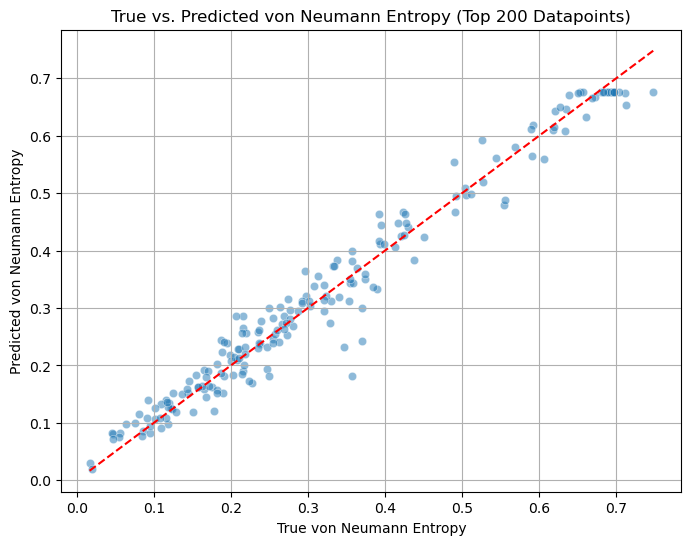

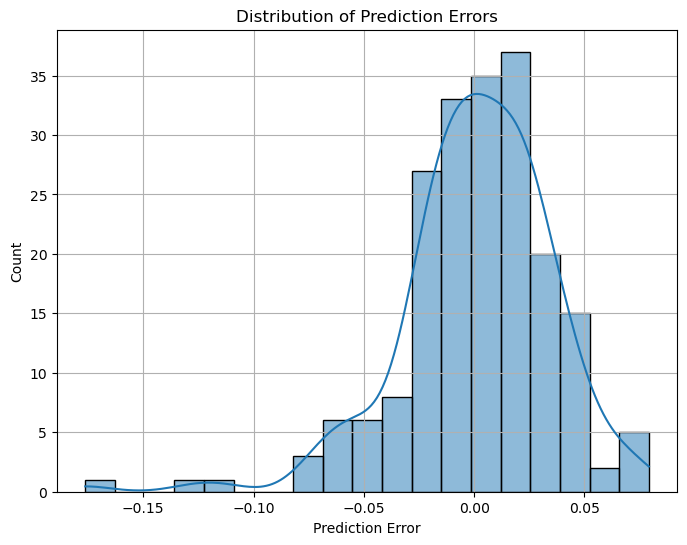

In [28]:
import os
import random
import logging
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


CONFIG = {
    'new_data_path': r'C:\Users\amssa\Documents\Codes\1-6\data1-6.parquet',  
    'processed_dir': './processed_new',
    'processed_file': 'data.pt',
    'scalers_path': 'scalers.pkl', 
    'batch_size': 256,
    'random_seed': 42,
    'distance_threshold': 25,  
    'model_path': 'best_gnn_model2.pth', 
    'hidden_channels': 256,
    'dropout_p': 0.3,
    'edge_attr_dim': 2,  
    'num_datapoints': 200 
}

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[logging.StreamHandler()]
    )

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

setup_logging()
set_seed(CONFIG['random_seed'])

class NewSpinSystemDataset(InMemoryDataset):
    def __init__(self, dataframe, root='.', transform=None, pre_transform=None):
        self.df = dataframe
        super(NewSpinSystemDataset, self).__init__(root, transform, pre_transform)
        if os.path.exists(self.processed_paths[0]):
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [CONFIG['processed_file']]

    def download(self):
        pass

    def process(self):
        data_list = []
        for idx, row in self.df.iterrows():
            Nx = row['Nx']
            Ny = 2
            N = Nx * Ny

            x_spacing = row['x_spacing']
            y_spacing = row['y_spacing']
            positions = np.array([
                (col * x_spacing, row_idx * y_spacing)
                for row_idx in range(Nx) for col in range(Ny)
            ], dtype=np.float32)
            positions = torch.tensor(positions, dtype=torch.float32)

            # Normalize positions
            pos_min = positions.min(dim=0).values
            pos_max = positions.max(dim=0).values
            normalized_positions = (positions - pos_min) / (pos_max - pos_min + 1e-8)

            state_indices = row['Top_50_Indices']
            state_probs = row['Top_50_Probabilities']

            p_rydberg = [0.0] * N
            for state, prob in zip(state_indices, state_probs):
                state = int(state)
                for i in range(N):
                    if state & (1 << i):
                        p_rydberg[i] += prob
            p_rydberg = torch.tensor(p_rydberg, dtype=torch.float32).unsqueeze(1)

            # N_A feature
            N_A_idx = int(row['N_A'])
            N_A_feature = torch.zeros((N, 1), dtype=torch.float32)
            if 0 <= N_A_idx < N:
                N_A_feature[N_A_idx] = 1.0

            # Concatenate node features: [normalized_x, normalized_y, p_rydberg, N_A]
            node_features = torch.cat([normalized_positions, p_rydberg, N_A_feature], dim=1)  # [N,4]

            # Edge construction
            distance_threshold = CONFIG['distance_threshold']
            nbrs = NearestNeighbors(radius=distance_threshold, algorithm='ball_tree').fit(positions.numpy())
            indices = nbrs.radius_neighbors(positions.numpy(), return_distance=False)

            edge_index = []
            for i_node in range(N):
                for j_node in indices[i_node]:
                    if i_node < j_node:
                        edge_index.append([i_node, j_node])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            if edge_index.size(1) > 0:
                pos_i = positions[edge_index[0]]
                pos_j = positions[edge_index[1]]
                distances = torch.norm(pos_i - pos_j, dim=1, keepdim=True)
                epsilon = 1e-8
                inv_r6 = 1.0 / (distances.pow(6) + epsilon)
            else:
                inv_r6 = torch.empty((0, 1), dtype=torch.float32)

            # Compute edge correlations
            edge_tuples = [(edge_index[0, k].item(), edge_index[1, k].item()) for k in range(edge_index.size(1))]
            edge_joint_probs = {edge: 0.0 for edge in edge_tuples}

            for state, prob in zip(state_indices, state_probs):
                state = int(state)
                rydberg_particles = [i_part for i_part in range(N) if state & (1 << i_part)]
                for i_part in rydberg_particles:
                    for j_part in rydberg_particles:
                        if i_part < j_part and (i_part, j_part) in edge_joint_probs:
                            edge_joint_probs[(i_part, j_part)] += prob

            edge_correlation = []
            for k in range(edge_index.size(1)):
                i_part = edge_index[0, k].item()
                j_part = edge_index[1, k].item()
                joint_prob = edge_joint_probs.get((i_part, j_part), 0.0)
                p_ryd_i = p_rydberg[i_part].item()
                p_ryd_j = p_rydberg[j_part].item()
                correlation = joint_prob - p_ryd_i * p_ryd_j
                edge_correlation.append([correlation])
            edge_correlation = torch.tensor(edge_correlation, dtype=torch.float32)

            if edge_index.size(1) > 0:
                edge_attr = torch.cat([inv_r6, edge_correlation], dim=1)
            else:
                edge_attr = torch.empty((0, 2), dtype=torch.float32)

            # Target: Von Neumann Entropy (apply log transform)
            entropy = torch.tensor([row['Von_Neumann_Entropy']], dtype=torch.float32)
            entropy = torch.log(entropy + 1e-9)

            data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=entropy)

            # Additional features (Omega, Delta, Energy)
            data.Omega = torch.tensor([[row['Omega']]], dtype=torch.float32)
            data.Delta = torch.tensor([[row['Delta']]], dtype=torch.float32)
            data.Energy = torch.tensor([[row['Energy']]], dtype=torch.float32)

            data_list.append(data)

        data, slices = self.collate(data_list)
        os.makedirs(self.root, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

from torch_geometric.nn import NNConv, BatchNorm, GlobalAttention
class ImprovedGNNModel(nn.Module):
    def __init__(self, num_node_features, edge_attr_dim, hidden_channels, dropout_p=0.5):
        super(ImprovedGNNModel, self).__init__()
        torch.manual_seed(CONFIG['random_seed'])

        nn_edge1 = nn.Sequential(
            nn.Linear(edge_attr_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, num_node_features * hidden_channels)
        )
        self.conv1 = NNConv(num_node_features, hidden_channels, nn_edge1, aggr='mean')
        self.bn1 = BatchNorm(hidden_channels)

        nn_edge2 = nn.Sequential(
            nn.Linear(edge_attr_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels * hidden_channels)
        )
        self.conv2 = NNConv(hidden_channels, hidden_channels, nn_edge2, aggr='mean')
        self.bn2 = BatchNorm(hidden_channels)

        nn_edge3 = nn.Sequential(
            nn.Linear(edge_attr_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels * hidden_channels)
        )
        self.conv3 = NNConv(hidden_channels, hidden_channels, nn_edge3, aggr='mean')
        self.bn3 = BatchNorm(hidden_channels)

        self.dropout = nn.Dropout(p=dropout_p)

        gate_nn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1)
        )
        self.global_pool = GlobalAttention(gate_nn=gate_nn)

        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            BatchNorm(hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Linear(hidden_channels * 2, hidden_channels),
            BatchNorm(hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Linear(hidden_channels, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x1 = self.conv1(x, edge_index, edge_attr)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)

        x2 = self.conv2(x1, edge_index, edge_attr)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = x2 + x1

        x3 = self.conv3(x2, edge_index, edge_attr)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = x3 + x2

        x3 = self.dropout(x3)
        x_pooled = self.global_pool(x3, batch)
        out = self.fc(x_pooled)
        return out.squeeze()

def main():
    # Load new test data
    if not os.path.exists(CONFIG['new_data_path']):
        logging.error(f"New test data file not found at {CONFIG['new_data_path']}")
        return
    df = pd.read_parquet(CONFIG['new_data_path'])

    # Take only the first N datapoints
    N = CONFIG['num_datapoints']
    df = df.head(N)

    # Shuffle optional if needed
    df = df.sample(frac=1, random_state=CONFIG['random_seed']).reset_index(drop=True)

    dataset = NewSpinSystemDataset(df, root=CONFIG['processed_dir'])
    logging.info(f"New test dataset loaded with {len(dataset)} graphs (first {N} datapoints).")

    # Load scalers
    scalers = joblib.load(CONFIG['scalers_path'])
    logging.info("Scalers loaded.")

    features = ['Omega', 'Delta', 'Energy']
    def normalize(dataset, scalers):
        for data in dataset:
            for feature in features:
                scaled = scalers[feature].transform(getattr(data, feature).numpy())
                setattr(data, feature, torch.tensor(scaled, dtype=torch.float))
        return dataset

    dataset = normalize(dataset, scalers)

    test_loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f'Using device: {device}')

    num_node_features = dataset[0].num_node_features
    edge_attr_dim = dataset[0].edge_attr.shape[1]
    model = ImprovedGNNModel(
        num_node_features=num_node_features,
        edge_attr_dim=edge_attr_dim,
        hidden_channels=CONFIG['hidden_channels'],
        dropout_p=CONFIG['dropout_p']
    ).to(device)

    model.load_state_dict(torch.load(CONFIG['model_path'], map_location=device))
    model.eval()
    logging.info("Model loaded and set to eval mode.")

    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            log_pred = model(data.x, data.edge_index, data.edge_attr, data.batch)
            # Convert back to original scale
            y_pred = torch.exp(log_pred)
            y_true = torch.exp(data.y.squeeze())

            y_true_list.append(y_true.cpu().numpy())
            y_pred_list.append(y_pred.cpu().numpy())

    y_true_all = np.concatenate(y_true_list)
    y_pred_all = np.concatenate(y_pred_list)

    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    nonzero_mask = (y_true_all != 0)
    if nonzero_mask.sum() > 0:
        mape = (np.abs((y_true_all[nonzero_mask] - y_pred_all[nonzero_mask]) / y_true_all[nonzero_mask]) * 100).mean()
    else:
        mape = float('nan')

    logging.info(f'Test MSE: {mse:.6f}')
    logging.info(f'Test MAE: {mae:.6f}')
    logging.info(f'Test R2: {r2:.6f}')
    logging.info(f'Test MAPE: {mape:.2f}%')

    # Plot: True vs Predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.5)
    min_val = min(y_true_all.min(), y_pred_all.min())
    max_val = max(y_true_all.max(), y_pred_all.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True von Neumann Entropy')
    plt.ylabel('Predicted von Neumann Entropy')
    plt.title(f'True vs. Predicted von Neumann Entropy (Top {N} Datapoints)')
    plt.grid(True)
    plt.show()

    # Error distribution
    errors = y_pred_all - y_true_all
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
